Google Colab specific settings

In [1]:
from pathlib import Path
root_dir = "/content/drive/MyDrive/Colab Notebooks/dev/"
base_dir = root_dir + 'nn-sero-pytorch/randomforest/'
path = Path(base_dir)
NN_dir = root_dir + 'nn-sero-pytorch/'

!pip install lime

     |████████████████████████████████| 276kB 12.6MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=e19c993ea3b5b9ba71b10a69e659195ec6e67c5390db6dfa48f8c374ee46660b
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [ ]:
from pathlib import Path

root_dir = '../'
base_dir = root_dir + 'randomforest/'
path = Path(base_dir)
NN_dir = '../'

In [2]:
import pandas as pd
import numpy as np
import sys
import math
import lime
import lime.lime_tabular
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
#from sklearn.multioutput import MultiOutputClassifier
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from collections import defaultdict
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.inspection import permutation_importance
#from sklearn.model_selection import train_test_split

def metrics(print_all='no'):
    loci = ['A', 'B', 'C', 'DQB1', 'DRB1']
    #loci = ['A']

    # function to check if value can be an integer - to eliminate excess characters from serology labels
    def checkInt(x):
        try:
            int(x)
            return True
        except ValueError:
            return False

    concordances = {}

    for loc in loci:
        newDict = {}
        simDict = {}
        diffDict = {}
        oldPredict = {}
        newPredict = {}
        oldPredFile = Path(NN_dir + "old-predictions/" + loc + ".chile")
        newPreds = pd.read_csv(base_dir + "predictions/" + loc + "_predictions.csv")
        newPreds = newPreds.set_index('allele')
        newPreds = newPreds.to_dict()
        newPredict = newPreds["serology"]
        for nKey in newPredict.keys():
            adjustMe = newPredict[nKey]
            adjustMe = adjustMe.replace('[','')
            adjustMe = adjustMe.replace(']','')
            adjustMe = adjustMe.replace(' ','')
            adjustMe = adjustMe.replace("'",'')
            adjustMe = adjustMe.split(',')
            newPredict[nKey] = [x.strip('a') for x in adjustMe if checkInt(x)]
        with open(oldPredFile, "r") as handle:
            for line in handle:
                if line.find('%') == -1:
                    next
                else:
                    line = line.split()
                    if line == []:
                        next
                    else:
                        line[:] = [x for x in line if (x != '[100.00%]')]
                        allele = loc + "*" + str(line[0][:-1])
                        oldPredict[allele] = line[1:]

        if loc == 'C':
            skipc = ['C*01', 'C*02', 'C*03', 'C*04', 'C*05', 'C*06', 'C*07', 'C*08']
            oldPredict = {k:v for k,v in oldPredict.items() if k[:4] in skipc}
            newPredict = {k:v for k,v in newPredict.items() if k[:4] in skipc}


        for each in oldPredict.keys():
            allDict = {}
            allDict["Allele"] = each
            allDict["Old Assignment"] = oldPredict[each]
            if each not in newPredict.keys():
                next
            else:
                allDict["New Assignment"] = newPredict[each]
                if set(newPredict[each]) != set(oldPredict[each]):
                    diffDict[each] = allDict
                elif set(newPredict[each]) == set(oldPredict[each]):
                    simDict[each] = allDict
        diffFrame = pd.DataFrame.from_dict(diffDict)
        diffFrame = diffFrame.transpose()
        diffFrame.to_csv(base_dir + "comparison/" + loc + "_compfile.csv", index=False)
        simFrame = pd.DataFrame.from_dict(simDict)
        simFrame = simFrame.transpose()
        simFrame.to_csv(base_dir + "comparison/" + loc + "_similar.csv", index=False)
        

        for allele in newPredict.keys():
            allDict = {}
            allDict["Allele"] = allele
            allDict["Serologic Assignment"] = newPredict[allele]
            if allele not in oldPredict.keys():
                newDict[allele] = allDict
        newFrame = pd.DataFrame.from_dict(simDict)
        newFrame = newFrame.transpose()
        newFrame.to_csv(base_dir + "comparison/" + loc + "_newsies.csv", index=False)

        simLen = len(simFrame)
        diffLen = len(diffFrame)
        with open(base_dir + "comparison/" + loc + "_concordance.txt", "w+") as fhandle:
            fhandle.write("HLA-" +loc+ " Similar: " + str(simLen))
            fhandle.write("HLA-" +loc+ " Different: " + str(diffLen))
            concordance = (simLen / (simLen + diffLen)) * 100
            concordances[loc] = concordance
            fhandle.write("HLA-" +loc+ " Concordance: " + str(concordance) + "%")
            if print_all == "yes":
                print("HLA-" +loc+ " Similar: " + str(simLen))
                print("HLA-" +loc+ " Different: " + str(diffLen))
                print("HLA-" +loc+ " Concordance: " + str(concordance) + "%")
    return concordances

#main(print_all="yes")

In [3]:
np.set_printoptions(threshold=sys.maxsize)

def one_hot_decode(df):
	df['serology']=''

	for col in df.columns:
		df.loc[df[col]==1,'serology'] = df['serology']+col+';'

	return df

def fix_data(uniques, data, loc, iset, ident):
    sero = {}
    for row in data.itertuples(name='Pandas'):
        sero[row.allele] = str(row.serology)
        #sero[row[1]] = str(row[-1])
  	
    data = data.drop('serology', axis=1)
  
    for key in sero.keys():
        '''
    	    # not applicable for old_sets train/test
        if (sero[key].find(';') != -1):
            sero[key] = sero[key].replace('a','')
            sero[key] = sero[key].split(';')
        else:
            sero[key] = sero[key].replace('a','')
            sero[key] = [sero[key]]
        '''
  
        #for old_sets train/test
        sero[key] = sero[key].split(' ')
      
        for x in sero[key]:
            if (x not in uniques):
                uniques.append(x)
            else:
                continue
  
    uniques = list(map(int, uniques))
    uniques.sort()
    uniques = list(map(str, uniques))
    
    for y in uniques:
        data[y] = 0
  
    one_sero = {}
    for key in sero.keys():
        one_sero[key] = { some_key : ("1" if (some_key in sero[key]) else "0")
  	  	                    for some_key in uniques }
    one_df = pd.DataFrame.from_dict(one_sero)
    one_df = one_df.transpose()
    one_df.index.name = "allele"
    data = data.set_index('allele')
    data.update(one_df, overwrite=True)
    data.to_csv(base_dir + 'randfor/'+iset+'/'+loc+'_'+ident+'.csv', index=True)
    return data, uniques
  

In [ ]:
#RSEED = 0

pre_concord = metrics()

loci = ["A", "B", "C", "DQB1", "DRB1"]
print("Predicting...")
for loc in tqdm(loci):
    uniques = []
    print(loc)
    features = pd.read_csv(base_dir + "training/" + loc + "_train.csv")
    #features['serology'] = features['serology'].apply(lambda x: x.replace('a','').replace(';',' '))
    features, sers = fix_data(uniques, features,loc,iset='training',ident='train')
    vfeatures = pd.read_csv(base_dir + "training/" + loc + "_validation.csv")
    #vfeatures['serology'] = vfeatures['serology'].apply(lambda x: x.replace('a','').replace(';',' '))
    vfeatures, vsers = fix_data(uniques, vfeatures,loc,iset='training',ident='validation')
    test = pd.read_csv(base_dir + "testing/" + loc + "_test.csv")
    test = test.drop('serology', axis=1)
    test.to_csv(base_dir + 'randfor/testing/'+loc+'_test.csv', index=True)
  
    features = features.append(vfeatures)
    labels = np.array(features[sers])
    features = features.drop(sers, axis=1)
    features = features.reset_index()
    indices = features["allele"]
    indices = list(indices)
    features = features.drop('allele', axis=1)
    feature_list = list(features.columns)
    n_features = len(feature_list)
    maxfeat = int(math.sqrt(n_features))
  
    features = np.array(features)
    labels[labels!=labels]='0'
    features[features!=features]='0'
    features = features.astype(int)
    labels = labels.astype(int)
  
    test_idcs = test['allele']
    test = test.drop('allele', axis=1)
    #print(test.head(100))
    test_list = list(test.columns)
    test = np.array(test)
    test[test!=test]='0'
    test = test.astype(int)
    ind_labels = [str(x) for x in sers]

    all_predictions = []
    for idx in range(0,len(ind_labels)):
        ilabels = labels[:,idx]
        forest = RandomForestClassifier(n_estimators=500, bootstrap=True, max_features=maxfeat, n_jobs=-1)
        forest.fit(features,ilabels)
        predictions = forest.predict(test)
        all_predictions.append(predictions)

        ''' 
        # Feature Importance

        importances = forest.feature_importances_

        std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                    axis=0)
        indices = np.argsort(importances)[::-1]
        nz_importances = importances[importances!=0]
        nz_indices = indices[:len(nz_importances)]

        with open(base_dir+'feat_importance/'+loc+'-'+ind_labels[idx]+'_rank.txt', 'w+') as handle:
            # Print the feature ranking
            handle.write("Feature ranking: \n")
            for x in range(features.shape[1]):
                handle.write("%d. feature %s (%f)\n" % (x + 1, feature_list[indices[x]], importances[indices[x]]))

        with open(base_dir+'feat_importance/'+loc+'-'+ind_labels[idx]+'_nzrank.txt', 'w+') as handle:
            # Print the feature ranking
            handle.write("Feature ranking: \n")
            for y in range(len(nz_indices)):
                handle.write("%d. feature %s (%f)\n" % (y + 1, feature_list[nz_indices[y]], importances[nz_indices[y]]))

        # Plot the impurity-based feature importances of the forest
        f = plt.figure()
        plt.title("Feature importances")
        #plt.bar(range(features.shape[1]), importances[indices],
        #        color="r", yerr=std[indices], align="center")
        #
        #plt.xticks(range(features.shape[1]), indices)
        #plt.xlim([-1, features.shape[1]])
        
        plt.bar(range(len(nz_indices)), importances[nz_indices],
                color="r", yerr=std[nz_indices], align="center")
        nzlabs = [feature_list[nz_indices[i]] for i in range(0, len(nz_indices))] 
        plt.xticks(range(len(nz_indices)), nzlabs, rotation='vertical', fontsize=3) 
        plt.xlim([-1, len(nz_indices)])
        plt.tight_layout()
        
        
        #plt.show()
        #f = plt.figure()
        f.savefig(base_dir+'feat_importance/'+loc+'-'+ind_labels[idx]+"_nz.pdf", bbox_inches='tight')

        plt.bar(range(features.shape[1]), importances[indices],
                color="r", yerr=std[indices], align="center")  
        labs = [feature_list[indices[j]] for j in range(0, len(indices))]
        plt.xticks(range(features.shape[1]), labs, rotation='vertical', fontsize=3)
        plt.xlim([-1, features.shape[1]])
        plt.tight_layout()
        f.savefig(base_dir+'feat_importance/'+loc+'-'+ind_labels[idx]+".pdf", bbox_inches='tight')
        plt.clf()

        '''
        # Permutation Importance
        result = permutation_importance(forest, features, ilabels, n_repeats=2, random_state=0, n_jobs=-1)
        perm_sorted_idx = result.importances_mean.argsort()
        print(perm_sorted_idx)

        with open(base_dir+'perm_importance/'+loc+'-'+ind_labels[idx]+'_rank.txt', 'w+') as handle:
            # Print the feature ranking
            handle.write("Feature ranking: \n")
            for x in range(features.shape[1]):
                handle.write("%d. feature %s (%f)\n" % (x + 1, feature_list[indices[x]], importances[indices[x]]))

        tree_importance_sorted_idx = np.argsort(forest.feature_importances_)
        tree_indices = np.arange(0, len(forest.feature_importances_)) + 0.5

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
        ax1.barh(tree_indices,
                forest.feature_importances_[tree_importance_sorted_idx], height=0.7)
        ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])
        ax1.set_yticks(tree_indices)
        ax1.set_ylim((0, len(forest.feature_importances_)))
        ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
                    labels=data.feature_names[perm_sorted_idx])
        fig.tight_layout()
        f = plt.figure()
        f.savefig(base_dir+'perm_importance/'+loc+'-'+ind_labels[idx]+".pdf", bbox_inches='tight')
        #plt.show()
        

    all_predictions = np.asarray(all_predictions)
    all_predictions = np.transpose(all_predictions)

    #explainer = lime.lime_tabular.LimeTabularExplainer(features,feature_names=feature_list,class_names=ind_labels,kernel_width=5)
    #for rowexp in range(0,2):
    #  exp = explainer.explain_instance(test[rowexp], forest.predict_proba, num_features=maxfeat)
    #  exp.show_in_notebook(show_table=True)
  
    #preds_output = pd.DataFrame(predictions, index=test_idcs, columns=ind_labels)
    preds_output = pd.DataFrame(all_predictions, index=test_idcs, columns=ind_labels)
    preds_output = one_hot_decode(preds_output)
    preds_output = preds_output.drop(ind_labels, axis=1)
    preds_output.index.name = 'allele'
    preds_output = preds_output.apply(lambda x: str((x['serology'].split(';'))[:-1]), result_type='broadcast', axis=1)
    preds_output.to_csv(base_dir + 'predictions/'+loc+'_predictions.csv', index=True)

print("Done.")




  0%|          | 0/5 [00:00<?, ?it/s]

Predicting...
A


In [ ]:
post_concord = metrics()

for loc in loci:
	print(loc + " Concordance:\t\t\t\t" + str(post_concord[loc])[:5] + "%")
	change = post_concord[loc] - pre_concord[loc]
	print("% Change:\t\t\t\t" + str(change)[:5] + "%")

A Concordance:				94.61%
% Change:				0.236%
B Concordance:				83.11%
% Change:				0.176%
C Concordance:				86.85%
% Change:				12.77%
DQB1 Concordance:				86.95%
% Change:				-0.72%
DRB1 Concordance:				90.53%
% Change:				0.697%


Feature ranking:
1. feature 225 (0.087509)
2. feature 55 (0.071417)
3. feature 584 (0.063105)
4. feature 71 (0.042562)
5. feature 184 (0.041923)
6. feature 239 (0.039151)
7. feature 183 (0.033770)
8. feature 543 (0.032522)
9. feature 11 (0.030986)
10. feature 238 (0.030400)
11. feature 587 (0.024533)
12. feature 2 (0.023875)
13. feature 204 (0.023839)
14. feature 235 (0.022173)
15. feature 6 (0.022122)
16. feature 7 (0.021203)
17. feature 575 (0.020658)
18. feature 34 (0.020283)
19. feature 203 (0.020165)
20. feature 9 (0.020163)
21. feature 569 (0.020147)
22. feature 10 (0.018319)
23. feature 5 (0.017632)
24. feature 298 (0.014211)
25. feature 544 (0.012845)
26. feature 3 (0.012806)
27. feature 29 (0.011824)
28. feature 255 (0.011484)
29. feature 736 (0.011369)
30. feature 732 (0.010966)
31. feature 610 (0.007844)
32. feature 576 (0.007692)
33. feature 0 (0.007330)
34. feature 1 (0.006858)
35. feature 456 (0.006699)
36. feature 657 (0.006298)
37. feature 43 (0.006285)
38. feature 448 

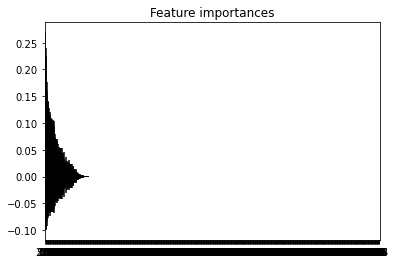

In [ ]:
import pandas as pd
import numpy as np

loci = ['A', 'B', 'C', 'DQB1', 'DRB1']
summary = {}

# dict of dicts to store splits of broad specificities
broad_split = {
    "A" : {
        "9" : ["23", "24"],
        "10" : ["25", "26", "34", "66"],
        "19" : ["29", "30", "31", "32", "33", "74"],
        "28" : ["68", "69"]
    },
    "B" : {
        "5" : ["51", "52"],
        "12" : ["44", "45"],
        "14" : ["64", "65"],
        "15" : ["62", "63", "75", "76", "77"],
        "16" : ["38", "39"],
        "17" : ["57", "58"],
        "21" : ["49", "50"],
        "22" : ["54", "55", "56"],
        "40" : ["60", "61"],
        "70" : ["71", "72"]
    },
    "C" : {
        "3" : ["9", "10"]
    },
    "DQB1" : {
        "1" : ["5", "6"],
        "3" : ["7", "8", "9"]
    },
    "DRB1" : {
        "2" : ["15", "16"],
        "3" : ["17", "18"],
        "5" : ["11", "12"],
        "6" : ["13", "14"]
    }
}

# dict of dict to store broad specificity for each split
split_broad = {}

for alphakey in broad_split.keys():
    sb = {}
    
    for betakey in broad_split[alphakey].keys():
        for value in broad_split[alphakey][betakey]:
            sb[value] = betakey
    
    split_broad[alphakey] = sb

# function to check if value can be an integer - to eliminate excess characters from serology labels
def checkInt(x):
    try:
        int(x)
        return True
    except ValueError:
        return False

# function to eliminate any serological assignments with under a 95% likelihood
def chance(x, line):
    if (line[x].find("%") != -1):
        x = float(line[x][:-1])
        if 51 <= x:
            test = True
        else:
            test = False
    else:
        test = False
    return test

# function to generate dataframes to contain SNNS predictions
def SNNS_preds(loci=loci):
    for loc in loci:
        oldPredict = {}
        oldPredFile = NN_dir + "old-predictions/" + loc + ".chile"
        with open(oldPredFile, "r") as handle:
            for line in handle:
                if line.find('%') != -1:
                    line = line.split()
                    if line != []:
                        line[:] = [x for x in line if x != '[100.00%]']
                        allele = loc + "*" + str(line[0][:-1])
                        oldPredict[allele] = ' '.join(line[1:])
                else:
                    next

        opseries = pd.Series(oldPredict, name="serology")
        opseries.index.name = "allele"
        opseries.reset_index()
        opseries.to_csv(NN_dir+"old-predictions/"+loc+"_predictions.csv", line_terminator='\n')
    return

# function to measure concordance between old SNNS and new ML models
def concordance(loci=loci):
    for loc in loci:
        comparison = open(NN_dir+"comparison/" + loc + "_compfile.txt", "w+")
        newsies = open(NN_dir+"comparison/" + loc + "_newsies.txt", "w+")
        similarities = open(NN_dir+"comparison/" + loc + "_similar.txt", "w+")
        oldPredict = {}
        newPredict = {}
        oldPredFile = NN_dir+"old-predictions/" + loc + ".chile"
        newPreds = pd.read_csv(NN_dir+"predictions/" + loc + "_predictions.csv")
        newPreds = newPreds.set_index('allele')
        newPreds = newPreds.to_dict()
        newPredict = newPreds["serology"]
        for nKey in newPredict.keys():
            adjustMe = str(newPredict[nKey])
            adjustMe = adjustMe.replace('[','')
            adjustMe = adjustMe.replace(']','')
            adjustMe = adjustMe.replace('a','')
            adjustMe = adjustMe.replace("'",'')
            adjustMe = adjustMe.split(' ')
            newPredict[nKey] = [x.strip('a') for x in adjustMe if checkInt(x)]
        with open(oldPredFile, "r") as handle:
            for line in handle:
                if line.find('%') == -1:
                    next
                else:
                    line = handle.readline()
                    line = line.split()
                    if line == []:
                        next
                    else:
                        line[:] = [x for x in line if x != '[100.00%]']
                        allele = loc + "*" + str(line[0][:-1])
                        oldPredict[allele] = line[1:]

        for each in oldPredict.keys():
            if each not in newPredict.keys():
                next
            elif set(newPredict[each]) != set(oldPredict[each]):
                comparison.write("Different: " + str(each) + "\n")
                comparison.write("Old Serologic Assignment: " + str(oldPredict[each]) + "\n")
                comparison.write("New Serologic Assignment: " + str(newPredict[each]) + "\n")
            elif set(newPredict[each]) == set(oldPredict[each]):
                similarities.write("Same: " + str(each) + "\n")
                similarities.write("Old Serologic Assignment: " + str(oldPredict[each]) + "\n")
                similarities.write("New Serologic Assignment: " + str(newPredict[each]) + "\n")
        comparison.close()
        similarities.close()

        for allele in newPredict.keys():
            if allele not in oldPredict.keys():
                newsies.write("NEW: " + str(allele) + "\n")
                newsies.write("Serologic Assignment: " + str(newPredict[allele]) + "\n")
        newsies.close()
    
    return
 
def summary_table(loci=loci, summary=summary):
    for locus in loci:
        summary_data = {}
        trn_set = pd.read_csv('training/' + locus + '_train.csv')
        val_set = pd.read_csv('training/' + locus + '_validation.csv')
        tst_set = pd.read_csv('testing/' + locus + '_test.csv')

        old_trn_set = pd.read_csv('old_sets/train/' + locus + '_train.csv')
        old_val_set = pd.read_csv('old_sets/train/' + locus + '_validation.csv')
        old_tst_set = pd.read_csv('old_sets/test/' + locus + '_test.csv')

        trnlen = float(len(trn_set))
        vallen = float(len(val_set))
        tstlen = float(len(tst_set))
        polyAA = float(len(trn_set.iloc[0])) - 1
        oldtrnlen = float(len(old_trn_set))
        oldvallen = float(len(old_val_set))
        oldtstlen = float(len(old_tst_set))
        oldpolyAA = float(len(old_trn_set.iloc[0])) - 1

        summary_data['Number of Training Alleles'] = trnlen
        summary_data['R-SNNS Number of Training Alleles'] = oldtrnlen
        summary_data['Difference in Training Set'] = trnlen - oldtrnlen
        summary_data['Percent (%) Growth in Training Set'] = ((trnlen - oldtrnlen)/oldtrnlen) * 100
        summary_data['Number of Validation Alleles'] = vallen
        summary_data['R-SNNS Number of Validation Alleles'] = oldvallen
        summary_data['Difference in Validation Set'] = vallen - oldvallen
        summary_data['Percent (%) Growth in Validation Set'] = ((vallen - oldvallen)/oldvallen) * 100
        summary_data['Number of Testing Alleles'] = tstlen
        summary_data['R-SNNS Number of Testing Alleles'] = oldtstlen
        summary_data['Difference in Testing Set'] = tstlen - oldtstlen
        summary_data['Percent (%) Growth in Testing Set'] = ((tstlen - oldtstlen)/oldtstlen) * 100
        summary_data['Number of Polymorphisms'] = polyAA
        summary_data['R-SNNS Number of Polymorphisms'] = oldpolyAA
        summary_data['Difference in Polymorphisms'] = polyAA - oldpolyAA
        summary_data['Percent (%) Growth in Polymorphisms'] = ((polyAA - oldpolyAA)/oldpolyAA) * 100
        summary[locus] = summary_data
        
    sum_df = pd.DataFrame(data=summary)

    sum_df.to_csv(NN_dir+'comparison/summary.csv', index=True)
    
    return

def evaluate(loc, p_allele, relser, right, wrong, partial, close, bad, broad_split=broad_split, split_broad=split_broad):
    p_ser = str(p_allele.serology).replace("'",'').replace('[','').replace(']','').replace('"','').replace(',','')
    p_ser = set(p_ser.split(' '))
    
    if p_allele.allele in relser.index:
        newser = set(relser.loc[p_allele.allele].serology.split(' '))
        if p_ser == newser:
            right.append(p_allele.allele)
        elif p_ser != newser:
            wrong.append(p_allele.allele)
            if any(w in newser for w in p_ser):
                partial.append(p_allele.allele)
            else:
                switch1 = "no"
                for oldval in p_ser:
                    if (oldval in list(broad_split[loc].keys())) or (oldval in list(split_broad[loc].keys())):
                        if oldval in list(broad_split[loc].keys()):
                            if any(x in newser for x in broad_split[loc][oldval]):
                                close.append(p_allele.allele)
                                switch1 = "yes"
                        elif oldval in list(split_broad[loc].keys()):
                            if any(y in newser for y in split_broad[loc][oldval]):
                                close.append(p_allele.allele)
                                switch1 = "yes"
                if switch1 == "no":
                    bad.append(p_allele.allele)

        return right, wrong, partial, close, bad
    
    else:
        
        return right, wrong, partial, close, bad

def met_pct(datalist, right, wrong, partial, close, bad):
    n_alleles = len(datalist)
    n_r = len(right)
    n_w = len(wrong)
    n_p = len(partial)
    n_c = len(close)
    n_b = len(bad)

    p_r = (n_r / n_alleles) * 100
    p_w = (n_w / n_alleles) * 100
    p_p = (n_p / n_alleles) * 100
    p_c = (n_c / n_alleles) * 100
    p_b = (n_b / n_alleles) * 100

    p_dict = {
        "All Calls Correct" : p_r,
        "Incorrect" : p_w,
        "At Least One Correct Call" : p_p,
        #"Close" : p_c,
        "All Calls Incorrect" : p_b,
    }

    return p_dict

def accuracy(loc, dataframe, relser):
    right = []
    wrong = []
    partial = []
    close = []
    bad = []

    for all in dataframe.iloc:
        # FIXME - A*23:19Q does not appear in rel_dna_ser (A*23:19N instead)
        # FIXME - B*07:44 does not appear in rel_dna_ser (B*07:44N instead)
        # FIXME - B*08:06 does not appear in rel_dna_ser at all
        # FIXME - B*49:15 does not appear in rel_dna_ser at all
        # FIXME - C*03:23 does not appear in rel_dna_ser (C*03:23N instead)
        # FIXME - C*03:99 does not appear in rel_dna_ser at all
        # FIXME - C*05:02 does not appear in rel_dna_ser at all
        # FIXME - C*07:226 does not appear in rel_dna_ser (C*07:226Q instead)
        if all.allele in ["A*23:19Q", "B*07:44", "B*08:06", "B*49:15", "C*03:23", "C*03:99", "C*05:02", "C*07:226"]:
            continue
        
        right, wrong, partial, close, bad = evaluate(loc, all, relser, right, wrong, partial, close, bad)

    df = relser[relser.index.isin(dataframe.allele)]

    met_dict = met_pct(df, right, wrong, partial, close, bad)

    return met_dict


def check_acc_all(loci=loci):
    mets = {
        "Old NN" : {},
        "New NN" : {},
        "Random Forest" : {},
    }

    for loc in loci:    
        old_nn_preds = pd.read_csv(NN_dir+"old-predictions/"+loc+"_predictions.csv", dtype=str)
        new_nn_preds = pd.read_csv(NN_dir+"predictions/"+loc+"_predictions.csv", dtype=str)
        new_nn_preds = new_nn_preds[new_nn_preds.allele.isin(old_nn_preds.allele)]
        rf_preds = pd.read_csv(NN_dir+"randomforest/predictions/"+loc+"_predictions.csv", dtype=str)
        #rf_preds = rf_preds[rf_preds.allele.isin(rf_preds.allele)]
        relser = pd.read_csv(NN_dir+"ser/"+loc+"_ser.csv", dtype=str)
        relser = relser.set_index('allele')
        relser = relser.dropna()

        mets["Old NN"][loc] = accuracy(loc, old_nn_preds, relser)
        mets["New NN"][loc] = accuracy(loc, new_nn_preds, relser)
        mets["Random Forest"][loc] = accuracy(loc, rf_preds, relser)

    return mets

def compare_acc(mets, opt1, opt2, loci=loci):
    c_dict = {}
    for loc in loci:
        l_dict = {}
        r1 = mets[opt1][loc]['All Calls Correct']
        w1 = mets[opt1][loc]['Incorrect']
        p1 = mets[opt1][loc]['At Least One Correct Call']
        #c1 = mets[opt1][loc]['Close']
        b1 = mets[opt1][loc]['All Calls Incorrect']
        r2 = mets[opt2][loc]['All Calls Correct']
        w2 = mets[opt2][loc]['Incorrect']
        p2 = mets[opt2][loc]['At Least One Correct Call']
        #c2 = mets[opt2][loc]['Close']
        b2 = mets[opt2][loc]['All Calls Incorrect']

        l_dict['All Calls Correct'] = r2-r1
        l_dict['Incorrect'] = w2-w1
        l_dict['At Least One Correct Call'] = p2-p1
        #l_dict['Close'] = c2-c1
        l_dict['All Calls Incorrect'] = b2-b1
        c_dict[loc] = l_dict

    return c_dict

def compare_acc_all(mets):
    cond1 = "New_vs_Old_NN"
    cond2 = "Random_Forest_vs_Old_NN"
    cond3 = "Random_Forest_vs_New_NN"

    opt1 = "Old NN"
    opt2 = "New NN"
    opt3 = "Random Forest"

    comp_dict = {
        cond1 : {},
        cond2 : {},
        cond3 : {},
    }

    comp_dict[cond1] = compare_acc(mets, opt1, opt2)
    cframe1 = pd.DataFrame.from_dict(comp_dict[cond1])
    cframe1.to_csv(NN_dir+'comparison/'+cond1+'.csv', index=True)
    comp_dict[cond2] = compare_acc(mets, opt1, opt3)
    cframe2 = pd.DataFrame.from_dict(comp_dict[cond2])
    cframe2.to_csv(NN_dir+'comparison/'+cond2+'.csv', index=True)
    comp_dict[cond3] = compare_acc(mets, opt2, opt3)
    cframe3 = pd.DataFrame.from_dict(comp_dict[cond3])
    cframe3.to_csv(NN_dir+'comparison/'+cond3+'.csv', index=True)

    return comp_dict

concordance()
mets = check_acc_all()
mframe1 = pd.DataFrame.from_dict(mets['Old NN'])
mframe1.to_csv(NN_dir+'comparison/OldNN_mets.csv', index=True)
mframe2 = pd.DataFrame.from_dict(mets['New NN'])
mframe2.to_csv(NN_dir+'comparison/NewNN_mets.csv', index=True)
mframe3 = pd.DataFrame.from_dict(mets['Random Forest'])
mframe3.to_csv(NN_dir+'comparison/RF_mets.csv', index=True)
print("Random Forest:")
print(mframe3.to_string())
print("RSNNS:")
print(mframe1.to_string())
comp_dict = compare_acc_all(mets)

                                   A          B          C       DQB1       DRB1
All Calls Correct          81.159420  85.751979  88.709677  85.714286  90.555556
Incorrect                  18.840580  14.248021  11.290323  14.285714   9.444444
At Least One Correct Call  12.560386   7.387863   9.677419  10.714286   6.111111
All Calls Incorrect         6.280193   6.860158   1.612903   3.571429   3.333333


In [ ]:
print("Random Forest:")
print(mframe3.to_string())
print('\n\n')
print("RSNNS:")
print(mframe1.to_string())

Random Forest:
                                   A          B          C       DQB1       DRB1
All Calls Correct          81.159420  85.751979  88.709677  85.714286  90.555556
Incorrect                  18.840580  14.248021  11.290323  14.285714   9.444444
At Least One Correct Call  12.560386   7.387863   9.677419  10.714286   6.111111
All Calls Incorrect         6.280193   6.860158   1.612903   3.571429   3.333333



RSNNS:
                                   A          B          C       DQB1       DRB1
All Calls Correct          84.343434  89.487871  85.000000  85.714286  90.449438
Incorrect                  15.656566  10.512129  15.000000  14.285714   9.550562
At Least One Correct Call  12.121212   5.929919  13.333333  10.714286   6.179775
All Calls Incorrect         3.030303   4.582210   1.666667   3.571429   3.370787


In [ ]:
# Previous version with MultiOutputClassifier
    '''
    forest = RandomForestClassifier(n_estimators=500, bootstrap=True, max_features=maxfeat, n_jobs=-1)
    multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)
    multi_target_forest.fit(features,labels)
    predictions = multi_target_forest.predict(test)
    print(predictions)
    '''